In [3]:
import os

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import Adam
from torch.distributions import MultivariateNormal, Normal
from torchvision.transforms import ToTensor
from torchvision.models import resnet18
import torch.nn.functional as F

from PIL import Image
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from utils import *
from get_data import *
from model import *

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DATAPATH = 'C:/Users/matan/Documents/data/coil-20-proc'
root_dir = DATAPATH + '/coil-20-proc'
csv_file = 'C:/Users/matan/Documents/data/coil-20-proc/labels.csv'
df = pd.read_csv(csv_file)

## Get data

Number of images in the dataset:  1440
Image shape: torch.Size([1, 128, 128])


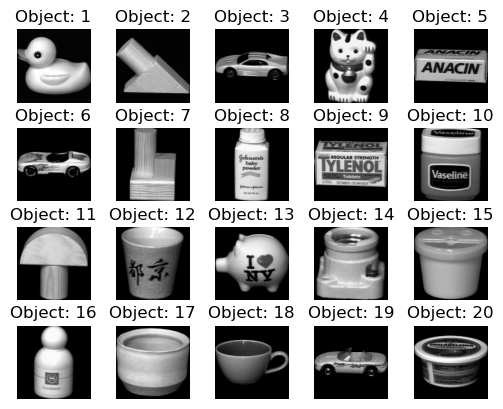

Training images:  20
Validation images:  710
Test images:  710


In [10]:
dataset = COIL20(root_dir, csv_file, transform=ToTensor())
N = len(dataset)
print("Number of images in the dataset: ", len(dataset))
img, label = dataset[0]
print("Image shape:", img.shape)

indices = {}
i = 0
while len(indices) < 20:
    _, label = dataset[i]
    if label not in indices.keys():
        indices[label] = i
    i += 1
    
fig = plt.figure()
gs = fig.add_gridspec(4,5, hspace=0.35, wspace=0)
axs = gs.subplots()
for l in range(20):
    img, label = dataset[indices[l+1]]
    assert label == l + 1
    r, c = (l)//5, l%5
    axs[r,c].imshow(img.permute(1,2,0), cmap=plt.get_cmap('gray'))
    axs[r,c].set_title("Object: " + str(label))
    axs[r,c].axis('off')
plt.show()

# Divide into train, test, and val
batch_size = 20
subset_idx = list(indices.values())
subset = torch.utils.data.Subset(dataset, subset_idx)

train_size = 20
val_size = int((N-20) / 2)
test_size = N - train_size - val_size

remaining_idx = [i for i in range(N) if i not in subset_idx]
remaining_data = torch.utils.data.Subset(dataset, remaining_idx)
val_data, test_data = random_split(remaining_data, [val_size, test_size])
print("Training images: ", len(subset))
print("Validation images: ", len(val_data))
print("Test images: ", len(test_data))

#kwargs = {'num_workers': 1, 'pin_memory': True} 
kwargs = {}
train_loader = DataLoader(subset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = DataLoader(test_data, len(test_data), shuffle=True, **kwargs)
val_loader = DataLoader(val_data, len(val_data), **kwargs)

# For access to the whole training set during evaluation
training_set = DataLoader(subset, train_size, shuffle=False, **kwargs)

# Create the Model

In [11]:
def loss_function(x, out, mean, log_var, N = 1152, beta = 1):
    """ Loss function for the model. """
    M = x.shape[0]      # Batch size

    x_hat=out
    reproduction_loss = ((x - x_hat)**2).sum(dim=(1,2,3))
    KL_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp(), dim=1)
    KL_divergence = KL_divergence * beta

    # SUM FOR BATCH LIKE IN KINGMA
    reproduction_loss = torch.sum(reproduction_loss, dim=0)
    KL_divergence = torch.sum(KL_divergence, dim=0)
    loss = (N/M) * KL_divergence + reproduction_loss

    return reproduction_loss + KL_divergence, reproduction_loss, KL_divergence

In [12]:
# Hyperparameters
lr = 0.01
in_channels = 1
input_size = [in_channels, 128, 128]
latent_dim = 32 #512
n_classes = 20
seed = 11       # Random seed for reproducible results
torch.manual_seed(seed);

model_overfit = VAE(z_dim=latent_dim, img_size=input_size).to(DEVICE)
print(model_overfit)

VAE(
  (encoder): ResNet18Enc(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlockEnc(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlockEnc(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    

# Fit the model

In [13]:
optimizer = Adam(model_overfit.parameters(), lr=lr)
print(DEVICE)

cuda


In [8]:
# Train the model
epochs = 500
validation_loss = []
train_losses = []
train_r_losses = []
train_kl_losses = []
beta_vals = []
step = 0
for epoch in range(epochs):
    model_overfit.train()
    loss_this_epoch = 0
    r_loss_this_epoch = 0
    kl_loss_this_epoch = 0
    for batch, (x, label) in enumerate(train_loader):
        batch_size = x.shape[0]
        x = x.to(DEVICE)

        assert not torch.isnan(x).any()
        optimizer.zero_grad()

        out, mean, logvar = model_overfit(x)
        x_hat = out

        if torch.isnan(x_hat.view(-1)).sum().item() != 0:
            print("Number of nans:", torch.isnan(x_hat.view(-1)).sum().item())
            print(x_hat)
        assert not torch.isnan(x_hat).any()
        
        #loss = loss_function(x, out, q_mean, q_log_var)
        beta = 0.1#0.001#beta_func(step)
        loss, r_loss, kl = loss_function(x, x_hat, mean, logvar, beta=beta)
        loss_this_epoch += loss.item() 
        r_loss_this_epoch += r_loss.item()
        kl_loss_this_epoch += kl.item()
        beta_vals.append(beta)
        step += 1

        loss.backward()
        optimizer.step()

    train_losses.append(loss_this_epoch / ((batch+1)*batch_size))
    train_r_losses.append(r_loss_this_epoch / ((batch+1)*batch_size))
    train_kl_losses.append(kl_loss_this_epoch / ((batch+1)*batch_size))
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", loss_this_epoch / ((batch+1)*batch_size))
    print("\t\t\t\tReproduction loss:", r_loss_this_epoch / ((batch+1)*batch_size) ,"\tKL-div:", kl_loss_this_epoch / ((batch+1)*batch_size))

    model_overfit.eval()
    with torch.no_grad():
        for batch, (x, label) in enumerate(val_loader):
            batch_size = x.shape[0]
            #x = x.view(batch_size, dim_input)   # Flatten
            x = x.to(DEVICE)
            x_hat, q_mean, q_log_var = model_overfit(x)
            loss, r_loss, kl = loss_function(x, x_hat, mean, logvar, beta=1)
            validation_loss.append(loss.item() / len(val_data))

	Epoch 1 complete! 	Average Loss:  2070.0115234375
				Reproduction loss: 2069.56640625 	KL-div: 0.4452090263366699
	Epoch 2 complete! 	Average Loss:  3740.47890625
				Reproduction loss: 3034.641796875 	KL-div: 705.837158203125
	Epoch 3 complete! 	Average Loss:  3004.66484375
				Reproduction loss: 2950.5802734375 	KL-div: 54.08463745117187
	Epoch 4 complete! 	Average Loss:  2095.023828125
				Reproduction loss: 1961.798828125 	KL-div: 133.22491455078125
	Epoch 5 complete! 	Average Loss:  2225.93828125
				Reproduction loss: 2052.325390625 	KL-div: 173.61292724609376
	Epoch 6 complete! 	Average Loss:  2279.534765625
				Reproduction loss: 2051.91171875 	KL-div: 227.62314453125
	Epoch 7 complete! 	Average Loss:  2297.8392578125
				Reproduction loss: 2153.9154296875 	KL-div: 143.92391357421874
	Epoch 8 complete! 	Average Loss:  1998.0060546875
				Reproduction loss: 1875.991796875 	KL-div: 122.0142822265625
	Epoch 9 complete! 	Average Loss:  1870.8486328125
				Reproduction loss: 1738.

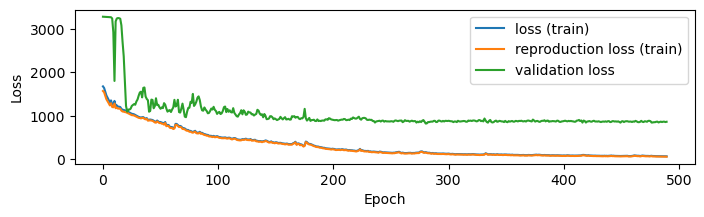

In [9]:
plt.figure(figsize=(8,2))
plt.plot(range(epochs-10), train_losses[10:], label = "loss (train)")
plt.plot(range(epochs-10), train_r_losses[10:], label = "reproduction loss (train)")
plt.plot(range(epochs-10), validation_loss[10:], label = 'validation loss')
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

<Figure size 400x200 with 0 Axes>

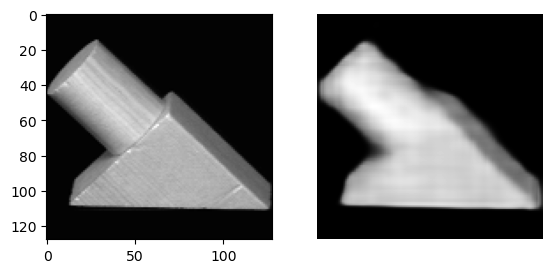

In [18]:
model_overfit.eval()
# See reconstruction of an image in the training set
examples = enumerate(train_loader)
with torch.no_grad():
    batch, (x, labels) = next(examples)
    x = x.to(DEVICE)
    x_hat, _, _ = model_overfit(x)

def show_image_in_batch(images, reconstructed_images, idx):
    images = images.view(images.shape[0], input_size[-2], input_size[-1])
    reconstructed_images = reconstructed_images.view(reconstructed_images.shape[0], input_size[-2], input_size[-1])
    plt.figure(figsize=(4,2))
    fig, axs = plt.subplots(1,2)
    axs[0].imshow(images[idx].cpu().numpy(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    axs[1].imshow(reconstructed_images[idx].cpu().numpy(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()

show_image_in_batch(x, x_hat, idx=0)

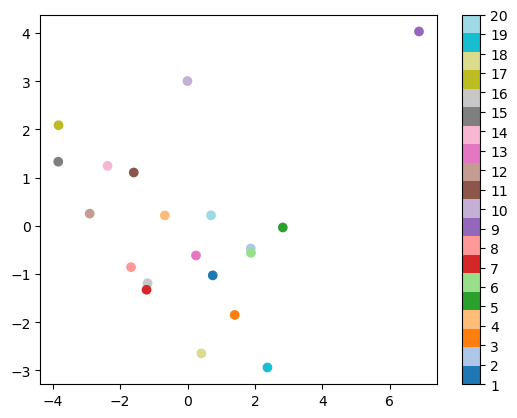

In [11]:
plot_latent_space_pca(model_overfit, training_set, n_batches=200)

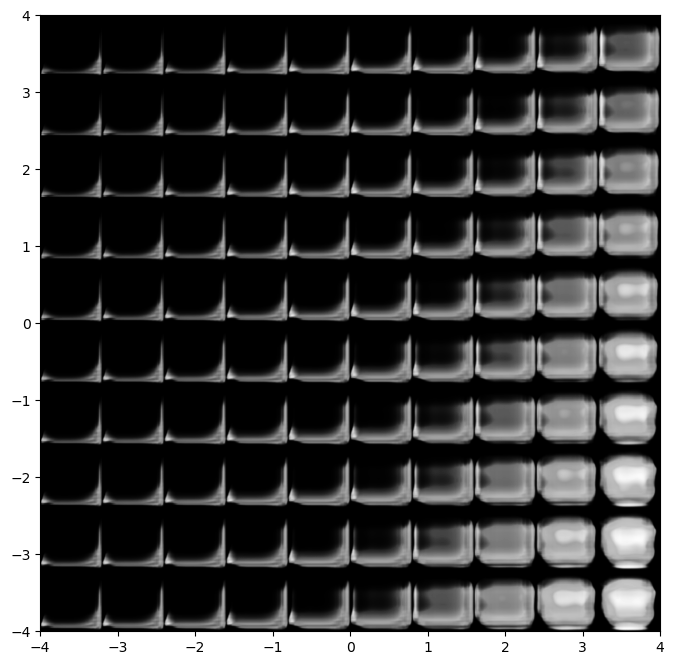

In [24]:
plot_reconstructed(model_overfit, ax0=(-4,4), ax1=(-4,4), dims=[0,1], n=10, img_size=input_size[-2:])

# Save and/or load trained model and results

In [7]:
RESULTS_PATH = os.path.join('C:\\Users\\matan\\OneDrive - Universitetet i Oslo\\Documents\\Projects\\vae-project', 'results\\models')

In [ ]:
print(RESULTS_PATH)
torch.save(model_overfit, os.path.join(RESULTS_PATH, 'VAE_COIL20_resnet_subset_overfit'))

In [15]:
# Load
model_overfit = torch.load(os.path.join(RESULTS_PATH, 'VAE_COIL20_resnet_subset_overfit'))